In [1]:
import json 
from pprint import pprint 
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import nltk
import re
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords

In [56]:
with open('AIRI_tokenizer_t2t_1000h_multi_32k.json', 'r', encoding='utf-8') as f: 
    text = json.load(f)
# print(json.dumps(text, indent=5, sort_keys=True))       

In [57]:
df = pd.read_json('AIRI_tokenizer_t2t_1000h_multi_32k.json', orient='index')
pprint(df)

                                                                0
version                                                       1.0
truncation                                                   None
padding                                                      None
added_tokens    [{'id': 0, 'content': '[UNK]', 'single_word': ...
normalizer      {'type': 'Sequence', 'normalizers': [{'type': ...
pre_tokenizer   {'type': 'Split', 'pattern': {'String': '-'}, ...
post_processor  {'type': 'BertProcessing', 'sep': ['[SEP]', 2]...
decoder                     {'type': 'BPEDecoder', 'suffix': ' '}
model           {'type': 'BPE', 'dropout': None, 'unk_token': ...


### We have:

1. missed tokens
2. features
3. annotations

In [58]:
import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams['figure.figsize'] = (8, 6)
matplotlib.rcParams['figure.dpi'] = 80

In [59]:
def classical_data_stat(data,y):  
    """
    Inputs : датасет
    Outpus : some statistics about dataset
    y: desired feature
    """
    
    print('There are {} observations'.format(data.shape[0]))
    print('There are {} columns \n'.format(data.shape[1]))
    print('------------------------------------------------')
    if not data.isnull().values.any():
        print('Нет пустых значений \n')
    else :   
        print('Есть пропуски \n')
    
    data[y].value_counts().plot(kind='bar')
    plt.title("Кол-во наблюдений")

In [60]:
def stat_dens(df, f):
    """
    Строит распределение конкретного признака в датасете
    """
    df_vc = pd.DataFrame(df[f].value_counts())
    df_vc.index.name = f
    df_vc.rename(columns = {f:'Количество'})
    sns.distplot(df[df[f] < df[f].quantile(0.9)][f],
                 bins= int(np.sqrt(df_vc.shape[0])), kde = False,
                color = 'b',hist_kws=dict(edgecolor = "black"))
    plt.grid()
    return df_vc

In [61]:
def search_token(df, st):
    """
    Поиск по первому слову LINE/SINE и т.д.
    """
    lst = [0]
    for index, i in enumerate(df.columns):
        if re.match(st, i):  # Ищет соответствие шаблону в начале строки
            lst.append(index)
    return df.iloc[:,np.array(lst)]

In [82]:
def plot_dist_multi(df, name):
    """
    Строит по классу переданному в функцию распределения подклассов
    """
    k = genes_el[name].size - genes_el[name].isna().sum()
    m = k//int(np.sqrt(k))
    n = int(np.sqrt(k))

    fig, myplot = plt.subplots(figsize = (25,20), nrows = m, ncols = n)
    features = search_token(df,name).columns[1:]
    row, col, num_cols = 0,0,n

    for u in features:
        df_vc = pd.DataFrame(df[u].value_counts())
        df_vc.index.name = u
        sns.distplot(df[df[u] < df[u].quantile(0.9)][u],
                     bins = int(np.sqrt(df_vc.shape[0])), 
                     kde = False,
                     color = 'blue',
                     hist_kws = dict(edgecolor = "black"),
                     ax =  myplot[row, col])
        myplot[row, col].set_xlabel("")
        myplot[row, col].grid()
        myplot[row, col].set_title(u, fontsize = 15)
        myplot[row, col].set_ylabel("Count", fontsize = 15)
        col = col + 1
        if col == n:
            col = 0
            row = row + 1
    plt.subplots_adjust(hspace = 0.5)
    plt.subplots_adjust(wspace = m*0.1)
    for v in range(m):
        for z in range(n):
            for patch in myplot[v,z].patches:
                label_x = patch.get_x()  # find midpoint of rectangle
                label_y = patch.get_y()
                #myplot[v,z].text(label_x, label_y, 
                                 #str(int(patch.get_height())) + '('+'{:.0%}'.format(
                                   #patch.get_height()/len(df.Survived))+')',
                               # horizontalalignment='center', verticalalignment='center')

In [38]:
#miss_df=pd.read_csv("bpe_tokens.missed_v2.tsv", sep='\t')
#miss_df.head(3)

In [39]:
#feature_df=pd.read_csv("bpe_tokens_v2.features.tsv", sep='\t')
#feature_df

#### EDA 

In [63]:
annot_df = pd.read_csv("bpe_tokens_v2.annotation.tsv", sep='\t')
annot_df.head(5)

,token,0,mRNA,gene,lnc_RNA,LINE/L1,CEN,SINE/Alu,transcript,exon,...,nucleotide_cleavage_site,replication_start_site,RNase_P_RNA,inverted_repeat,RNase_MRP_RNA,telomerase_RNA,sequence_comparison,dispersed_repeat,vault_RNA,Y_RNA
0,TAACC,0,1282391,997012,426916,316399,233807,58968,172319,71392,...,0,0,0,0,0,0,0,0,2,0
1,AACCC,0,1934030,1486832,561832,386286,351783,558508,259806,117284,...,0,0,0,0,0,1,0,0,1,1
2,ATAAC,0,1849383,1491680,785465,525559,355039,29012,249121,94879,...,0,0,0,0,0,0,0,2,0,1
3,TACCC,0,1196853,934321,386741,368700,248195,55700,157728,73182,...,0,0,0,0,0,0,0,0,0,0
4,TAAAC,0,2347864,1822905,788270,670641,362091,44252,317478,127204,...,0,0,0,0,0,0,0,0,0,0


In [64]:
annot_df.describe().T
### Описательная статистика

,count,mean,std,min,25%,50%,75%,max
0,31357.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
mRNA,31357.0,78881.106324,267633.044538,0.0,10816.0,21019.0,49888.0,8689365.0
gene,31357.0,61724.872788,209504.701000,0.0,8435.0,16471.0,39143.0,6795282.0
lnc_RNA,31357.0,26359.187741,92937.820400,0.0,3394.0,6777.0,16627.0,3059077.0
LINE/L1,31357.0,18851.417132,70048.453335,0.0,2098.0,4838.0,12455.0,2536336.0
...,...,...,...,...,...,...,...,...
telomerase_RNA,31357.0,0.014255,0.134190,0.0,0.0,0.0,0.0,4.0
sequence_comparison,31357.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
dispersed_repeat,31357.0,0.001786,0.049199,0.0,0.0,0.0,0.0,3.0
vault_RNA,31357.0,0.010077,0.136100,0.0,0.0,0.0,0.0,5.0


In [65]:
annot_df.info()
#### Общая информация по датасету ####

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31357 entries, 0 to 31356
Columns: 128 entries, token to Y_RNA
dtypes: int64(127), object(1)
memory usage: 30.6+ MB


In [66]:
annot_df.dtypes
### Предварительная проверка типов данных датасета #### 

token                  object
0                       int64
mRNA                    int64
gene                    int64
lnc_RNA                 int64
                        ...  
telomerase_RNA          int64
sequence_comparison     int64
dispersed_repeat        int64
vault_RNA               int64
Y_RNA                   int64
Length: 128, dtype: object

In [67]:
annot_df.isnull().sum()

token                  0
0                      0
mRNA                   0
gene                   0
lnc_RNA                0
                      ..
telomerase_RNA         0
sequence_comparison    0
dispersed_repeat       0
vault_RNA              0
Y_RNA                  0
Length: 128, dtype: int64

In [68]:
### Сколько всего типов ###

annot_df.dtypes.unique()

array([dtype('O'), dtype('int64')], dtype=object)

,lnc_RNA
lnc_RNA,
0,101
3130,10
3696,10
2756,9
3163,9
...,...
19751,1
13327,1
14366,1


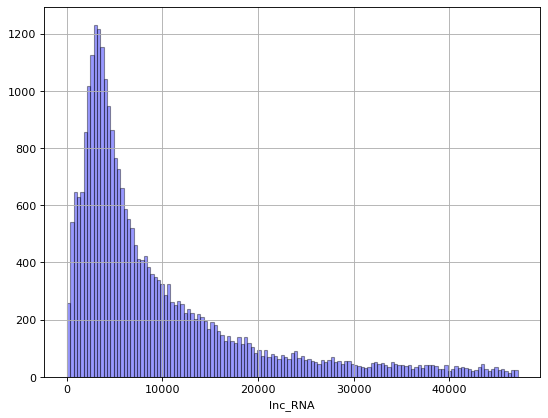

In [31]:
stat_dens(annot_df,'lnc_RNA') # Построим распределение lnc_RNA, также можно и для остальных если необходимо

In [69]:
search_token(annot_df,'LINE').head(3)
# ищем вхождение слова( LINE например)
# в датафрейме и выводит все подклассы связанные с ним( LINE/L1 и т.д )

,token,LINE/L1,LINE/L2,LINE/CR1,LINE/RTE-X,LINE/RTE-BovB,LINE/Dong-R4,LINE/Penelope,LINE/L1-Tx1,LINE/I-Jockey
0,TAACC,316399,57375,8539,2486,719,102,61,40,15
1,AACCC,386286,69132,8022,2136,670,78,58,36,27
2,ATAAC,525559,78862,11076,4021,1106,198,101,53,19


In [70]:
search_token(annot_df,'SINE').head(3)

,token,SINE/Alu,SINE/MIR,SINE/tRNA-RTE,SINE/5S-Deu-L2,SINE/tRNA,SINE/tRNA-Deu
0,TAACC,58968,86039,970,221,200,41
1,AACCC,558508,89379,811,208,192,76
2,ATAAC,29012,100015,684,246,173,33


In [71]:
search_token(annot_df,'DNA').head(3)

,token,DNA/hAT-Charlie,DNA/TcMar-Tigger,DNA/hAT-Tip100,DNA/TcMar-Mariner,DNA/hAT-Blackjack,DNA/TcMar-Tc2,DNA,DNA/MULE-MuDR,DNA/hAT-Ac,...,DNA/Crypton,DNA/Kolobok,DNA/Merlin,DNA/hAT-Tip100?,DNA/Crypton-A,DNA?/hAT-Tip100?,DNA/hAT?,DNA?,DNA/TcMar-Pogo,DNA/hAT-hAT19
0,TAACC,27569,26816,7152,1710,1864,845,860,379,447,...,48,17,26,27,36,24,10,2,3,0
1,AACCC,41367,29278,8605,1116,2433,607,834,688,367,...,19,26,21,12,26,9,12,3,3,3
2,ATAAC,41138,55069,11609,3059,2928,2176,1504,1021,857,...,67,35,74,32,43,26,30,5,1,2


In [72]:
search_token(annot_df,'LTR').head(3)

,token,LTR/ERVL-MaLR,LTR/ERV1,LTR/ERVL,LTR/ERVK,LTR/Gypsy,LTR
0,TAACC,62346,70846,43146,6008,3219,2692
1,AACCC,88995,95808,58898,7989,4583,2451
2,ATAAC,92015,74422,43700,9340,4603,3701


In [73]:
annot_df.head(2)

,token,0,mRNA,gene,lnc_RNA,LINE/L1,CEN,SINE/Alu,transcript,exon,...,nucleotide_cleavage_site,replication_start_site,RNase_P_RNA,inverted_repeat,RNase_MRP_RNA,telomerase_RNA,sequence_comparison,dispersed_repeat,vault_RNA,Y_RNA
0,TAACC,0,1282391,997012,426916,316399,233807,58968,172319,71392,...,0,0,0,0,0,0,0,0,2,0
1,AACCC,0,1934030,1486832,561832,386286,351783,558508,259806,117284,...,0,0,0,0,0,1,0,0,1,1


In [83]:
#### Выводим все генетические элементы для каждого класса(подклассы) ####

genes_el = pd.DataFrame.from_dict(dict (SINE = np.array(search_token(annot_df,'SINE').columns[1:]), 
               LINE = np.array(search_token(annot_df,'LINE').columns[1:]),
              LTR = np.array(search_token(annot_df,'LTR').columns[1:]),
              DNA = np.array(search_token(annot_df,'DNA').columns[1:])), orient='index').transpose(),

genes_el_= pd.DataFrame()

(              SINE           LINE            LTR                DNA
 0         SINE/Alu        LINE/L1  LTR/ERVL-MaLR    DNA/hAT-Charlie
 1         SINE/MIR        LINE/L2       LTR/ERV1   DNA/TcMar-Tigger
 2    SINE/tRNA-RTE       LINE/CR1       LTR/ERVL     DNA/hAT-Tip100
 3   SINE/5S-Deu-L2     LINE/RTE-X       LTR/ERVK  DNA/TcMar-Mariner
 4        SINE/tRNA  LINE/RTE-BovB      LTR/Gypsy  DNA/hAT-Blackjack
 5    SINE/tRNA-Deu   LINE/Dong-R4            LTR      DNA/TcMar-Tc2
 6             None  LINE/Penelope           None                DNA
 7             None    LINE/L1-Tx1           None      DNA/MULE-MuDR
 8             None  LINE/I-Jockey           None         DNA/hAT-Ac
 9             None           None           None            DNA/hAT
 10            None           None           None       DNA/PiggyBac
 11            None           None           None       DNA/hAT-Tag1
 12            None           None           None      DNA/TcMar-Tc1
 13            None           None

In [318]:
print('Количество подклассов LINE:', search_token(annot_df,'LINE').shape[1]-1)
print('Количество подклассов SINE:', search_token(annot_df,'SINE').shape[1]-1)
print('Количество подклассов LTR:', search_token(annot_df,'LTR').shape[1]-1)
print('Количество подклассов DNA:', search_token(annot_df,'DNA').shape[1]-1)

Количество подклассов LINE: 9
Количество подклассов SINE: 6
Количество подклассов LTR: 6
Количество подклассов DNA: 25


### Чтобы построить распределения всех подклассов входящих в определенный класс таких как SINE, LINE, LTR, DNA
### Функция plot_dist_multi поможет в этом, она строит распределения очищая длиннный хвост данных с маленькими значениями, благодаря ей графики становятся более читабельны
### Всего у нас имеется 4 класса, ниже приведены графики для ккаждого этого класса

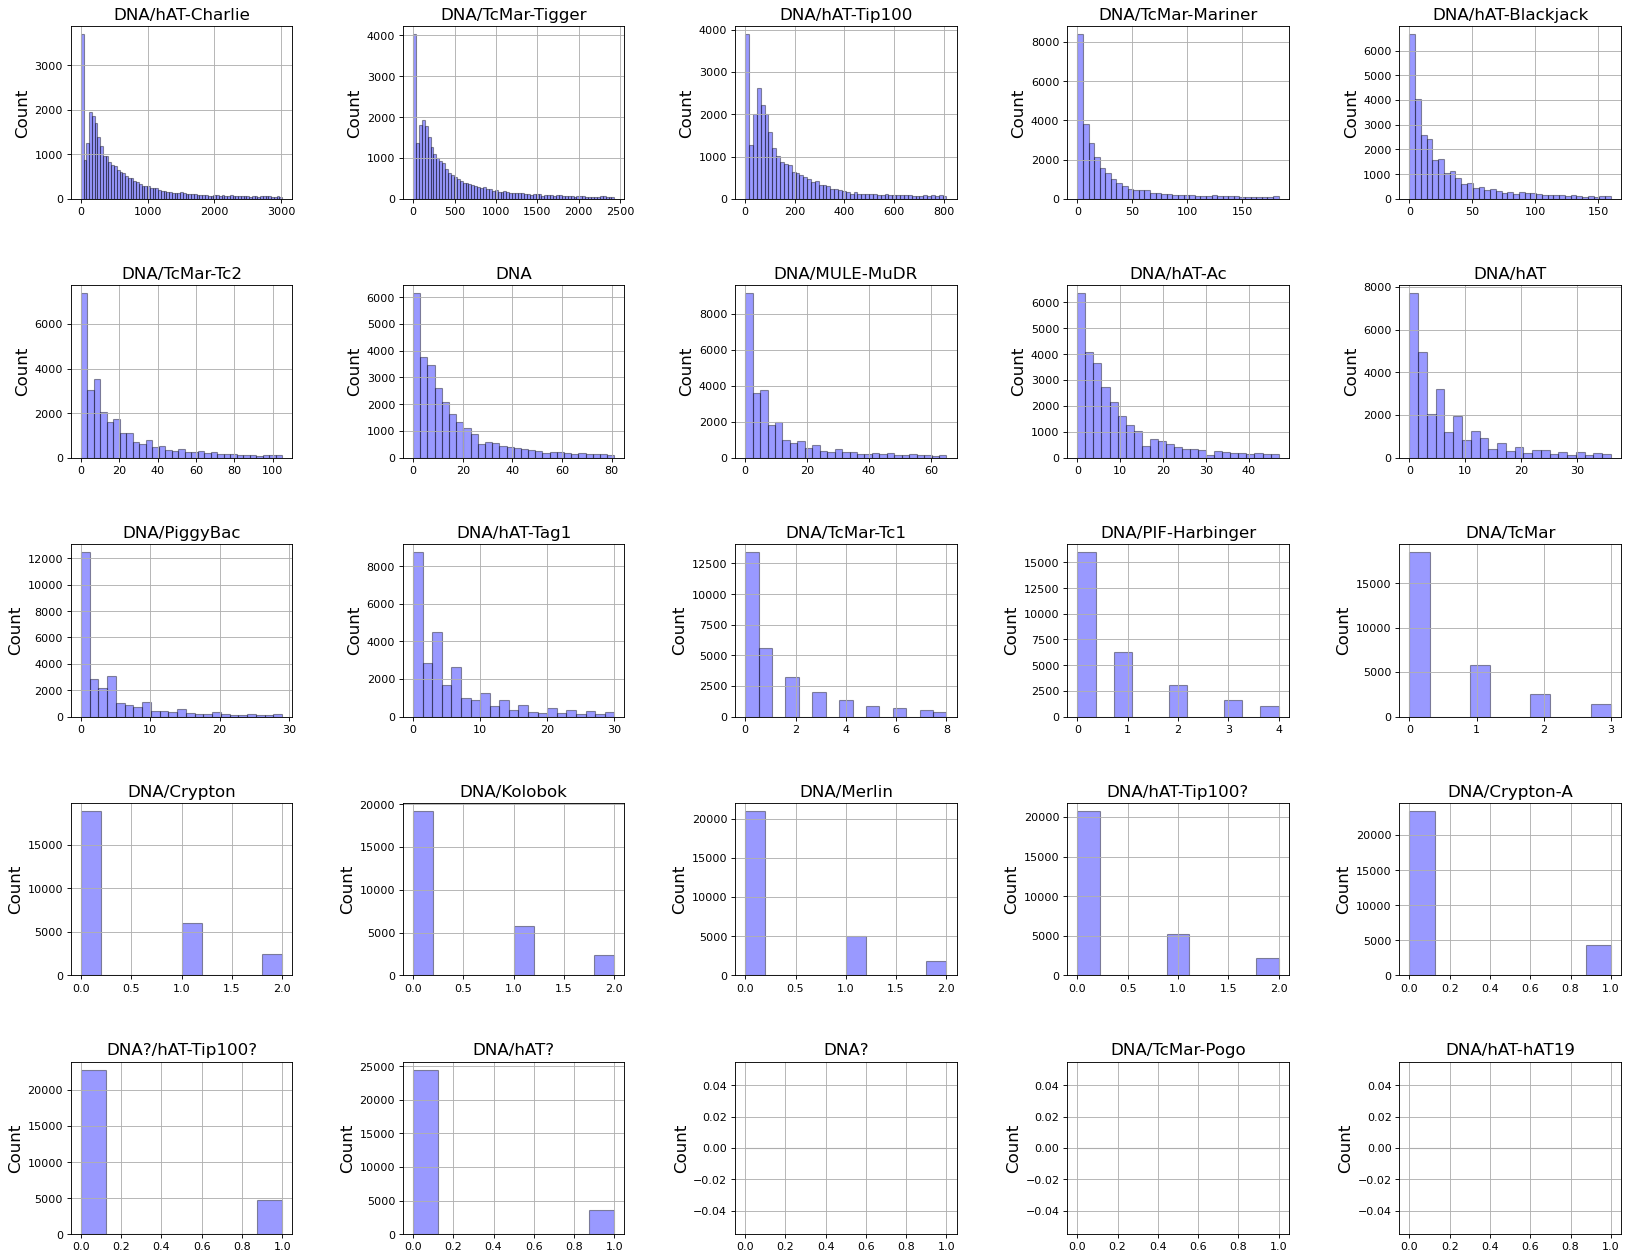

In [323]:
plot_dist_multi(annot_df, 'DNA')

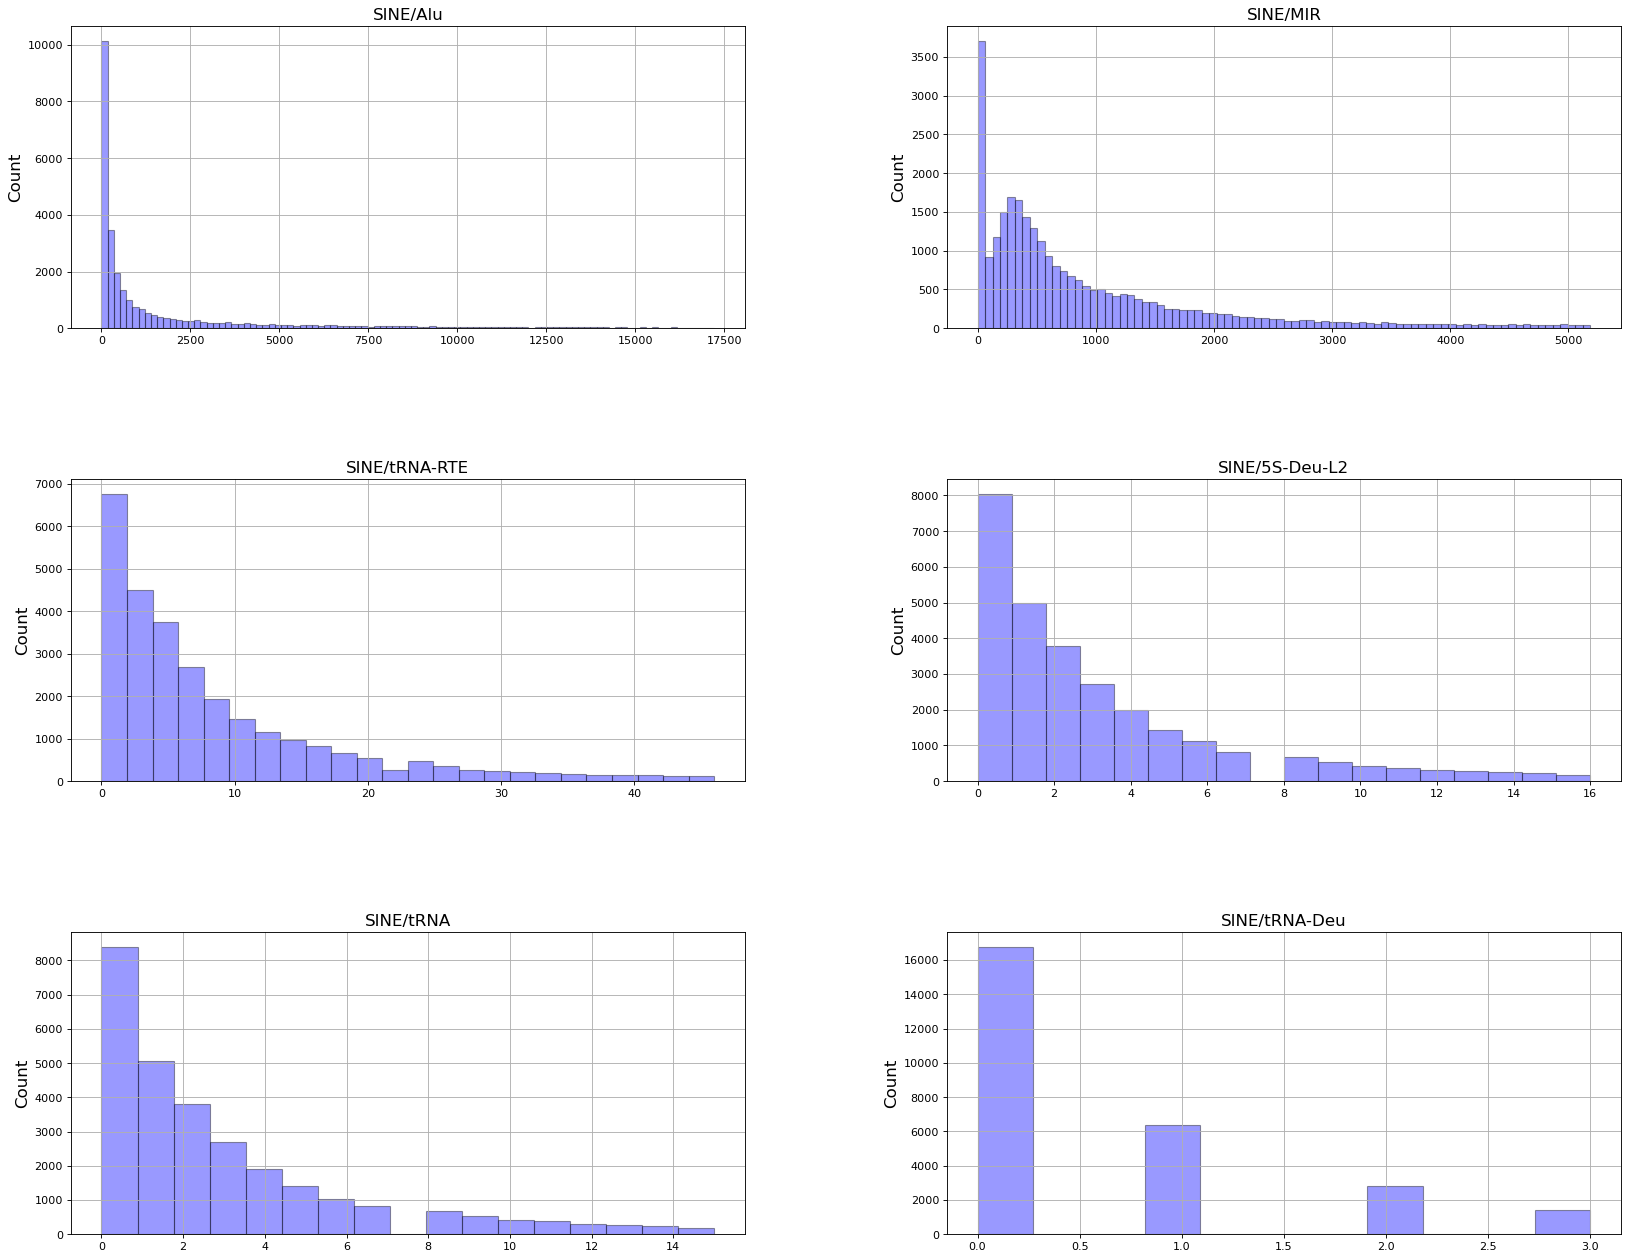

In [327]:
plot_dist_multi(annot_df, 'SINE')

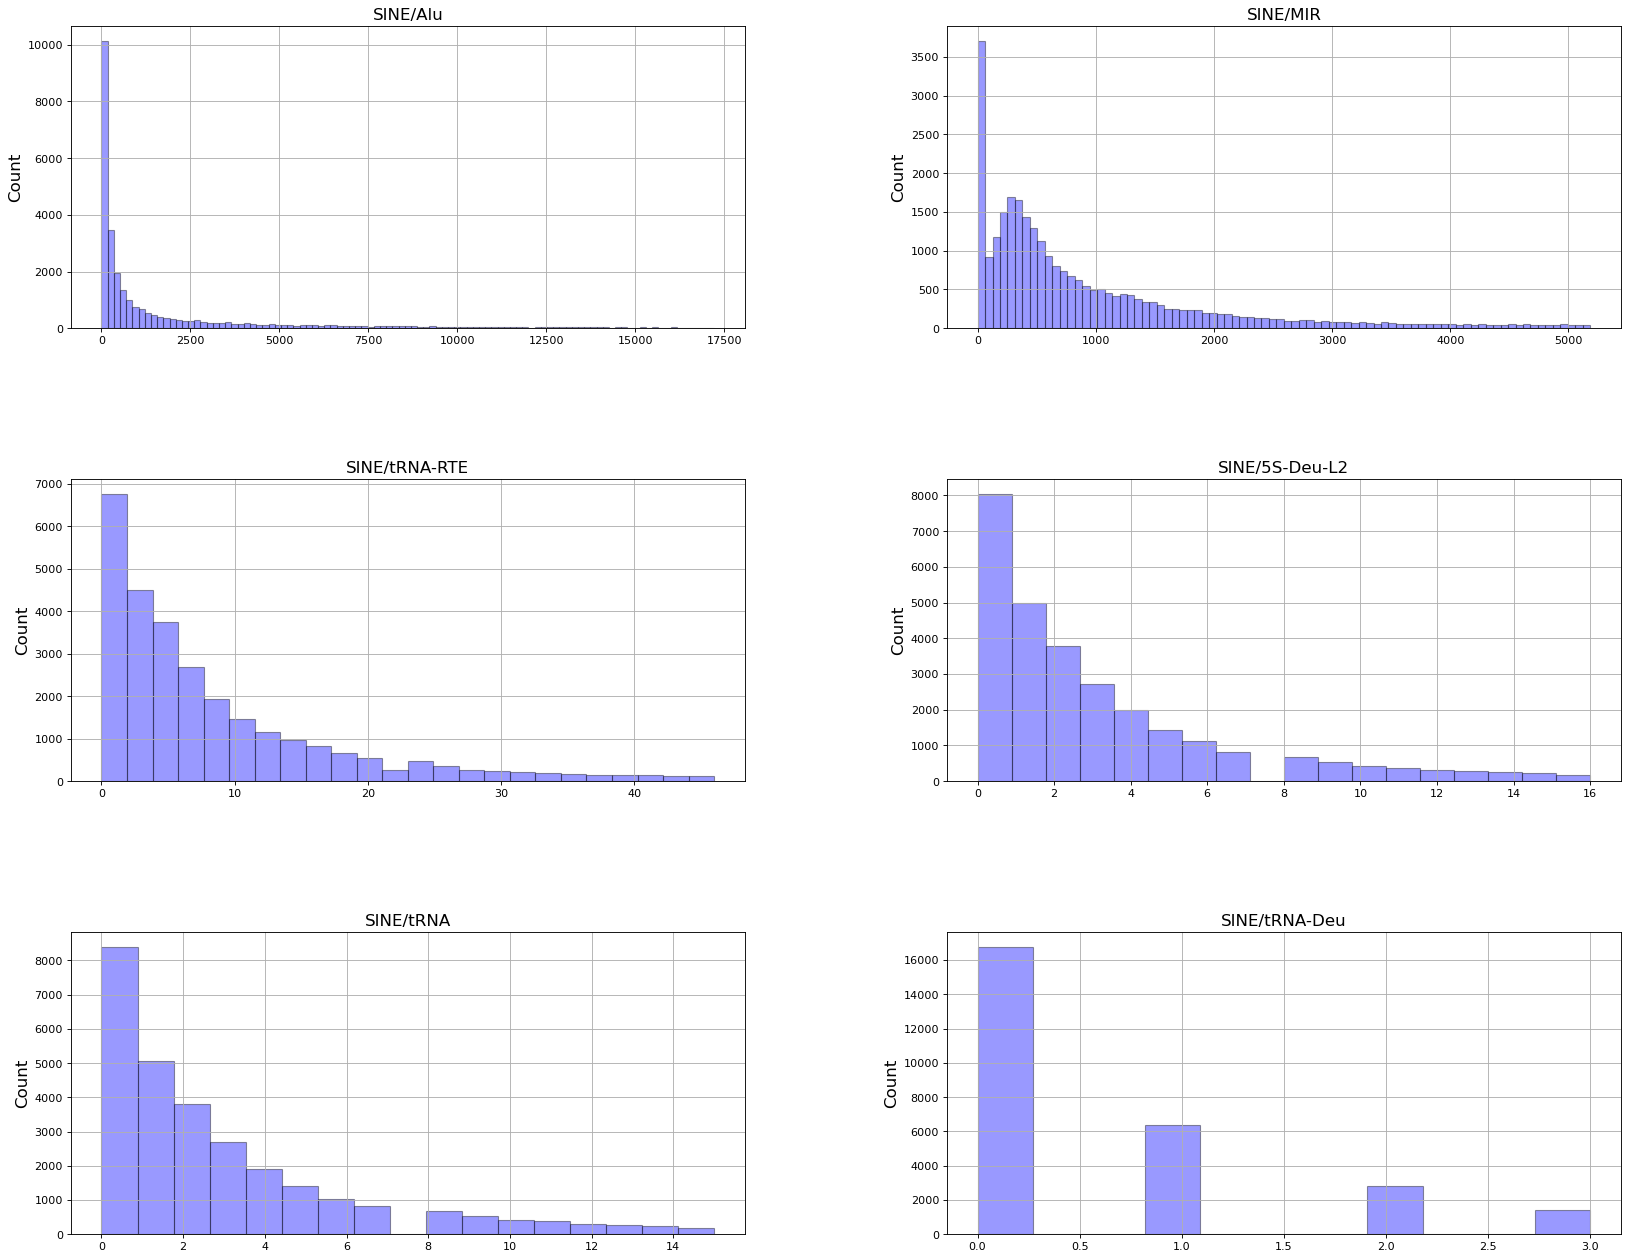

In [328]:
plot_dist_multi(annot_df, 'SINE')

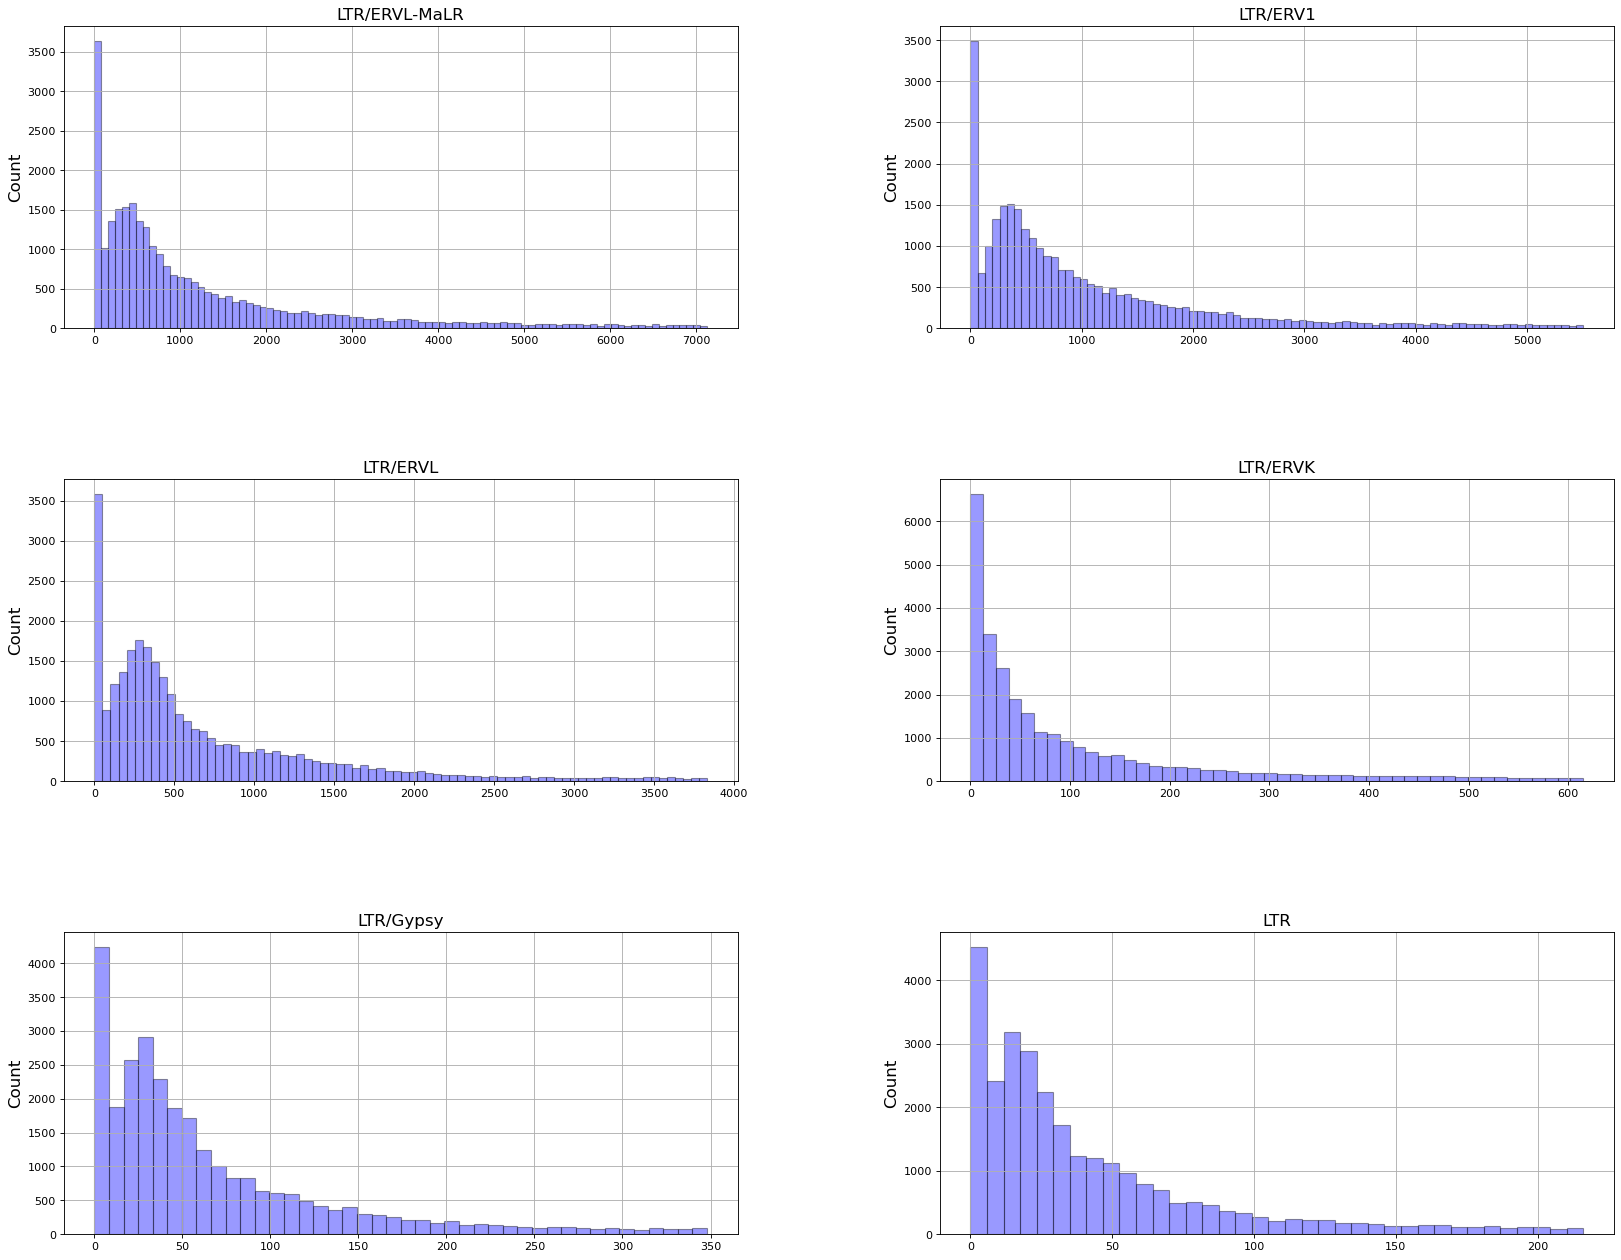

In [329]:
plot_dist_multi(annot_df, 'LTR')

In [277]:
#stat_dens(annot_df, 'DNA/hAT-Charlie')
#stat_dens(annot_df, 'DNA/TcMar-Tigger')
#stat_dens(annot_df, 'DNA/hAT-Tip100')
#plt.legend(labels=['DNA/hAT-Charlie', 'DNA/TcMar-Tigger',  'DNA/hAT-Tip100'])

In [330]:
#def stat_dens_сlasses(df,lst):
    #for i in lst:
        #stat_dens(df,i)

In [331]:
#stat_dens_сlasses(annot_df,search_token(annot_df,'LINE').columns.tolist()[1:])

In [ ]:
companydict = {elem : pd.DataFrame() for elem in compuniquenames}

In [343]:
genes_name = annot_df.columns
genes_name

Index(['token', '0', 'mRNA', 'gene', 'lnc_RNA', 'LINE/L1', 'CEN', 'SINE/Alu',
       'transcript', 'exon',
       ...
       'nucleotide_cleavage_site', 'replication_start_site', 'RNase_P_RNA',
       'inverted_repeat', 'RNase_MRP_RNA', 'telomerase_RNA',
       'sequence_comparison', 'dispersed_repeat', 'vault_RNA', 'Y_RNA'],
      dtype='object', length=128)

### Чтобы построить распределение конкретного признака и количество значений можно воспользоваться функцией stat_dens
### Передадим в нее сам датафрейм и имя признака(строка)
### Ниже предоставлен пример кода как это работает (так можно проглядеть его для каждого признакак который потребуется)

,gene
gene,
0,68
3,8
5,8
6734,8
1,7
...,...
32840,1
42347,1
14307,1


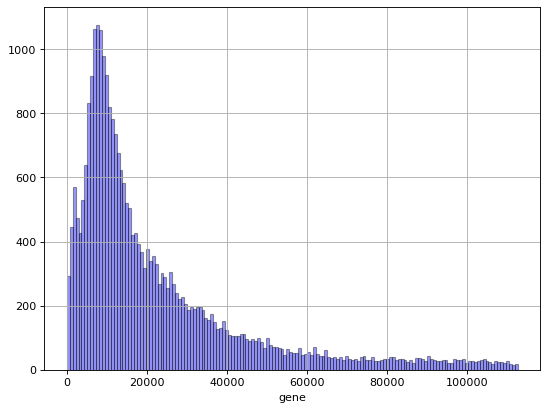

In [353]:
stat_dens(annot_df,'gene')

,mRNA
mRNA,
0,103
2,9
9495,6
10162,6
1,6
...,...
16194,1
2152255,1
24382,1


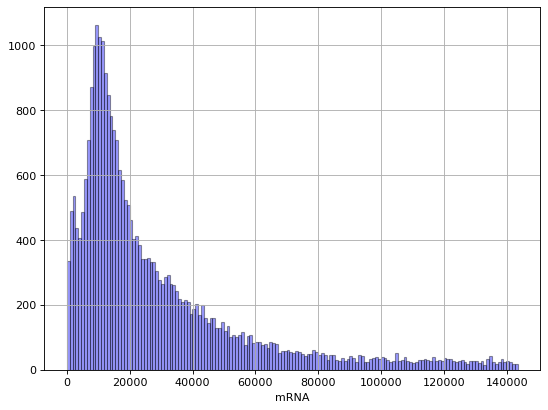

In [350]:
stat_dens(annot_df,'mRNA')

,transcript
transcript,
0,104
1243,22
1252,18
1170,18
1461,17
...,...
46418,1
3361,1
7511,1


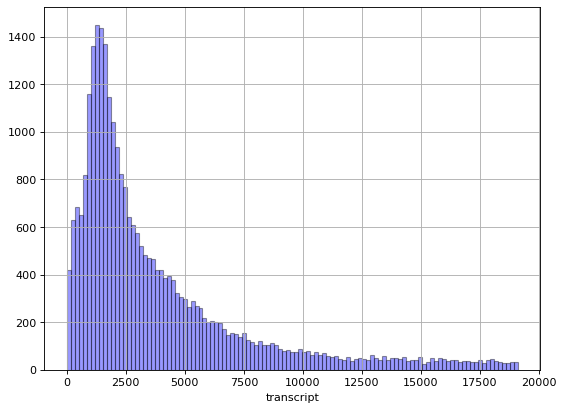

In [354]:
stat_dens(annot_df,'transcript')